In [2]:
%pip install --user annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 5.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=79705 sha256=b582f71ae4d85930ac3abfddfdb549b849490e729c181b4f713dbf0664a1429c
  Stored in directory: /home/ucloud/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from annoy import AnnoyIndex
import numpy as np
import joblib
import os

# Load the dataset
file_path = 'enriched_playlist_v2.csv'
data = pd.read_csv(file_path)

# Define features and target
X = data.drop(columns=['playlist_id', 'track_id', 'track_name', 'artist_name'])
y = data['playlist_id']

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Aggregate features for each playlist (mean of features for all tracks in the playlist)
playlist_features = X.groupby(y).mean()

# Get the number of dimensions in the feature space
num_features = playlist_features.shape[1]

# Initialize the Annoy index
annoy_index = AnnoyIndex(num_features, 'angular')

# Build the Annoy index using playlist features
for i, playlist_id in enumerate(playlist_features.index):
    annoy_index.add_item(i, playlist_features.loc[playlist_id].values)

# Specify the number of trees for building the index (higher number means better accuracy but slower indexing)
num_trees = 10
annoy_index.build(num_trees)

# Save the Annoy index
annoy_index_filename = 'annoy_index.ann'
annoy_index.save(annoy_index_filename)
print(f"Annoy index saved to {annoy_index_filename}")

# Load the Annoy index
annoy_index = AnnoyIndex(num_features, 'angular')
annoy_index.load(annoy_index_filename)

# Function to find fitting playlists given a song's features
def find_fitting_playlists(song_features, num_neighbors=10):
    # Get the nearest neighbors
    similar_indices = annoy_index.get_nns_by_vector(song_features, num_neighbors)
    # Decode the indices to get the original playlist IDs
    similar_playlists = label_encoder.inverse_transform(similar_indices)
    return similar_playlists

# Example usage: Find fitting playlists for a given song
# Replace this with actual song features
example_song_features = X.iloc[0].values  # Example: features of the first song in the dataset
fitting_playlists = find_fitting_playlists(example_song_features)
print(f"Playlists fitting the given song: {fitting_playlists}")


Annoy index saved to annoy_index.ann
Playlists fitting the given song: [874404 631690 825898 873798 301990 459115 967833 947189 399297 770547]


In [5]:
# Function to display playlist information including their means for each feature
def display_playlist_info(playlist_ids, original_data, aggregated_features):
    playlist_info = original_data[original_data['playlist_id'].isin(playlist_ids)].drop_duplicates(subset=['playlist_id'])
    playlist_info = playlist_info.merge(aggregated_features, on='playlist_id')
    return playlist_info

# Aggregate features for each playlist
aggregated_features = X.groupby(y).mean().reset_index()
aggregated_features.columns = ['playlist_id'] + [f"mean_{col}" for col in aggregated_features.columns[1:]]

# Display information for the fitting playlists
playlist_info = display_playlist_info(fitting_playlists, data, aggregated_features)
print(playlist_info)

   playlist_id  num_followers                track_id  \
0       301990              2  3dsQbL2pPOvCI7Hk1ib9tZ   
1       399297              1  0PrGgNDwfJPNXADJYROvBw   
2       459115              1  29U7stRjqHU6rMiS8BfaI9   
3       631690              1  7CpcZceLngQ4UWS3XAJfsE   
4       770547              1  4wpj4UlnLJPJ0skyRKoBCl   
5       825898             10  4Dj7LLTYKmqcqI9pVvNTqT   
6       873798              1  1M5a4uGEeeptMgQB639oja   
7       874404              1  4eSPgp7BuS9Yi4agcV4sAw   
8       947189              1  74X1epeRufHckhuX1KFD04   
9       967833              1  7tDKYoV4iDmuJmXHm5hGKV   

                                          track_name           artist_name  \
0  El Pueblo Unido (Jeremy Sole feat. Quantic Remix)  Thievery Corporation   
1                              In A Sentimental Mood        Duke Ellington   
2            What A Wonderful World - Single Version       Louis Armstrong   
3                                          Catgroove        

Feature importance based on perturbation analysis:
num_followers       1.0
danceability        1.0
energy              1.0
key                 1.0
loudness            1.0
mode                1.0
speechiness         1.0
acousticness        1.0
instrumentalness    1.0
liveness            1.0
valence             1.0
tempo               1.0
duration_ms         0.3
dtype: float64


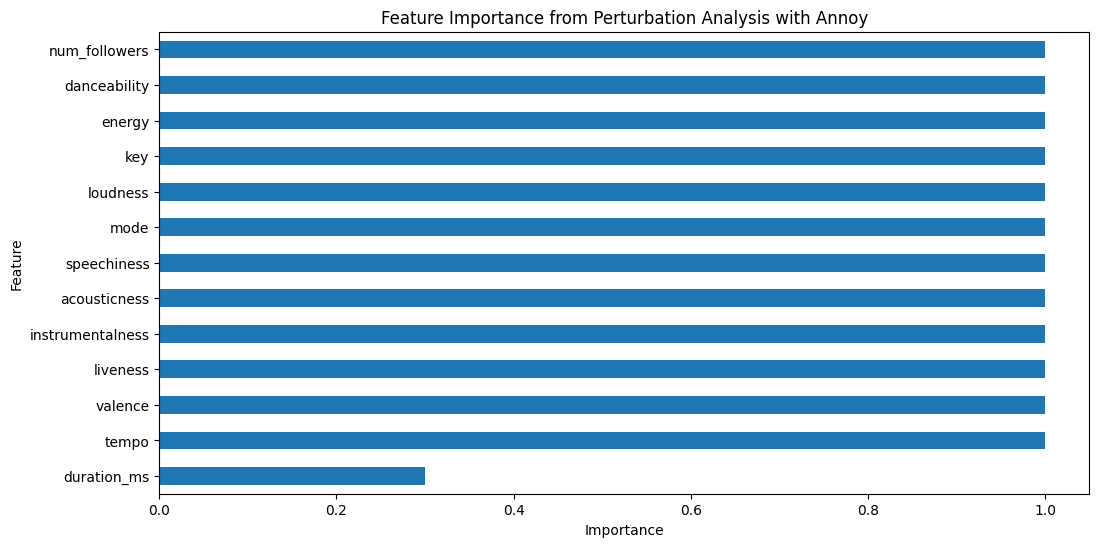

In [7]:
def perturb_feature_importance(original_features, perturbation_amount=0.2, num_neighbors=10):
    feature_importance = {}
    base_nearest = set(find_fitting_playlists(original_features, num_neighbors))
    
    for feature_index in range(len(original_features)):
        perturbed_features = original_features.copy()
        perturbed_features[feature_index] += perturbation_amount
        
        perturbed_nearest = set(find_fitting_playlists(perturbed_features, num_neighbors))
        common_neighbors = len(base_nearest.intersection(perturbed_nearest))
        
        feature_importance[X.columns[feature_index]] = common_neighbors / num_neighbors
    
    feature_importance = pd.Series(feature_importance).sort_values(ascending=False)
    return feature_importance

# Analyze feature importance through perturbation
perturbation_amount = 0.2
feature_importance = perturb_feature_importance(example_song_features, perturbation_amount)
print("Feature importance based on perturbation analysis:")
print(feature_importance)

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
feature_importance.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Perturbation Analysis with Annoy')
plt.gca().invert_yaxis()
plt.show()

In [8]:
# Function to perturb features and analyze impact
def perturb_feature_importance(original_features, perturbation_fraction=0.1, num_neighbors=10):
    feature_importance = {}
    base_nearest = set(find_fitting_playlists(original_features, num_neighbors))
    
    for feature_index in range(len(original_features)):
        perturbed_features = original_features.copy()
        perturbation_amount = perturbation_fraction * np.std(X_scaled[:, feature_index])
        perturbed_features[feature_index] += perturbation_amount
        
        perturbed_nearest = set(find_fitting_playlists(perturbed_features, num_neighbors))
        common_neighbors = len(base_nearest.intersection(perturbed_nearest))
        
        feature_importance[X.columns[feature_index]] = common_neighbors / num_neighbors
    
    feature_importance = pd.Series(feature_importance).sort_values(ascending=False)
    return feature_importance

# Analyze feature importance through perturbation
perturbation_fraction = 0.1
feature_importance = perturb_feature_importance(example_song_features, perturbation_fraction)
print("Feature importance based on perturbation analysis:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Perturbation Analysis with Annoy')
plt.gca().invert_yaxis()
plt.show()

NameError: name 'X_scaled' is not defined

Annoy index saved to annoy_index.ann
Playlists fitting the given song: [231881 893957 460999 192814 515023 876032 642874 867768 414407 874308]
Feature importance based on perturbation analysis:
num_followers       1.0
energy              1.0
tempo               1.0
liveness            1.0
danceability        0.9
loudness            0.9
key                 0.9
instrumentalness    0.9
valence             0.9
duration_ms         0.9
acousticness        0.8
mode                0.8
speechiness         0.8
dtype: float64


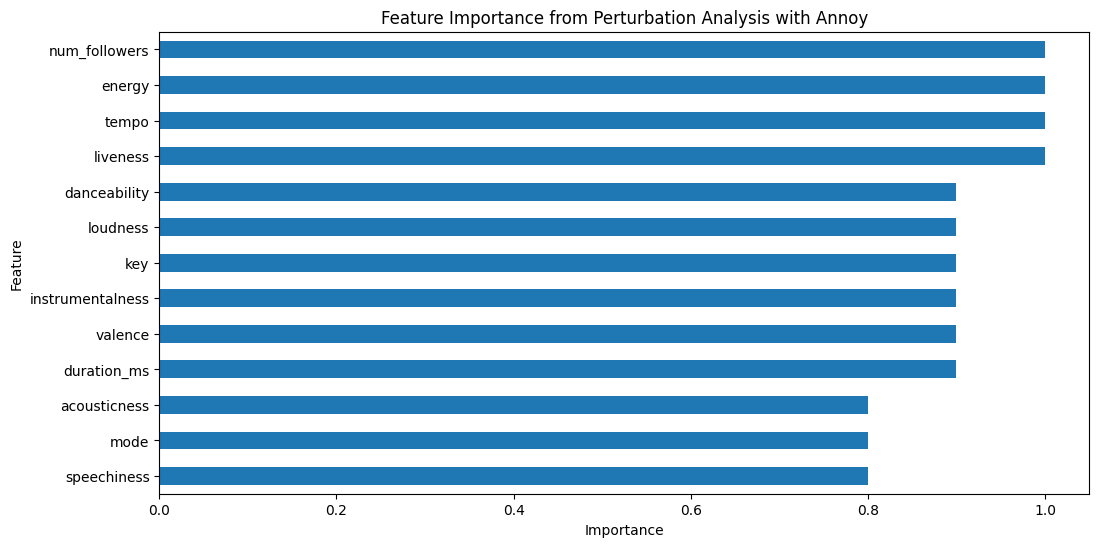

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from annoy import AnnoyIndex
import numpy as np
import joblib
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'enriched_playlist_v2.csv'
data = pd.read_csv(file_path)

# Define features and target
X = data.drop(columns=['playlist_id', 'track_id', 'track_name', 'artist_name'])
y = data['playlist_id']

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aggregate features for each playlist (mean of features for all tracks in the playlist)
playlist_features = pd.DataFrame(X_scaled).groupby(y).mean()

# Get the number of dimensions in the feature space
num_features = playlist_features.shape[1]

# Initialize the Annoy index
annoy_index = AnnoyIndex(num_features, 'angular')

# Build the Annoy index using playlist features
for i, playlist_id in enumerate(playlist_features.index):
    annoy_index.add_item(i, playlist_features.loc[playlist_id].values)

# Specify the number of trees for building the index (higher number means better accuracy but slower indexing)
num_trees = 10
annoy_index.build(num_trees)

# Save the Annoy index
annoy_index_filename = 'annoy_index.ann'
annoy_index.save(annoy_index_filename)
print(f"Annoy index saved to {annoy_index_filename}")

# Load the Annoy index
annoy_index = AnnoyIndex(num_features, 'angular')
annoy_index.load(annoy_index_filename)

# Function to find fitting playlists given a song's features
def find_fitting_playlists(song_features, num_neighbors=10):
    # Get the nearest neighbors
    similar_indices = annoy_index.get_nns_by_vector(song_features, num_neighbors)
    # Decode the indices to get the original playlist IDs
    similar_playlists = label_encoder.inverse_transform(similar_indices)
    return similar_playlists

# Example usage: Find fitting playlists for a given song
example_song_features = X_scaled[0]  # Example: features of the first song in the dataset
fitting_playlists = find_fitting_playlists(example_song_features)
print(f"Playlists fitting the given song: {fitting_playlists}")

# Function to perturb features and analyze impact
def perturb_feature_importance(original_features, perturbation_fraction=0.1, num_neighbors=10):
    feature_importance = {}
    base_nearest = set(find_fitting_playlists(original_features, num_neighbors))
    
    for feature_index in range(len(original_features)):
        perturbed_features = original_features.copy()
        perturbation_amount = perturbation_fraction * np.std(X_scaled[:, feature_index])
        perturbed_features[feature_index] += perturbation_amount
        
        perturbed_nearest = set(find_fitting_playlists(perturbed_features, num_neighbors))
        common_neighbors = len(base_nearest.intersection(perturbed_nearest))
        
        feature_importance[X.columns[feature_index]] = common_neighbors / num_neighbors
    
    feature_importance = pd.Series(feature_importance).sort_values(ascending=False)
    return feature_importance

# Analyze feature importance through perturbation
perturbation_fraction = 0.1
feature_importance = perturb_feature_importance(example_song_features, perturbation_fraction)
print("Feature importance based on perturbation analysis:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Perturbation Analysis with Annoy')
plt.gca().invert_yaxis()
plt.show()

In [11]:
%pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 7.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from dtaidistance import dtw
import numpy as np

# Load the dataset
file_path = 'enriched_playlist_v2.csv'
data = pd.read_csv(file_path)

# Define features and target
X = data.drop(columns=['playlist_id', 'track_id', 'track_name', 'artist_name', 'num_followers'])
y = data['playlist_id']

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aggregate features for each playlist using DTW
playlists = {playlist_id: X_scaled[y == playlist_id] for playlist_id in np.unique(y)}

# Function to compute DTW distance
def compute_dtw_distance(song_features, playlist_features):
    distances = []
    for playlist_song in playlist_features:
        distance = dtw.distance(song_features, playlist_song)
        distances.append(distance)
    return np.mean(distances)

# Function to find the best matching playlists based on DTW distance
def find_best_matching_playlists(song_features, playlists, num_neighbors=10):
    dtw_distances = {}
    for playlist_id, playlist_features in playlists.items():
        dtw_distance = compute_dtw_distance(song_features, playlist_features)
        dtw_distances[playlist_id] = dtw_distance
    
    sorted_playlists = sorted(dtw_distances, key=dtw_distances.get)[:num_neighbors]
    return sorted_playlists

# Example usage: Find best matching playlists for a given song
example_song_features = X_scaled[0]  # Example: features of the first song in the dataset
best_matching_playlists = find_best_matching_playlists(example_song_features, playlists)

# Map the best matching playlists indices to original playlist IDs
best_matching_playlists_ids = best_matching_playlists
print(f"Best matching playlists for the given song: {best_matching_playlists_ids}")

Best matching playlists for the given song: [14171, 279082, 642874, 303506, 147116, 780958, 564966, 328756, 986171, 279616]


In [13]:
# Save the necessary models and data
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(playlists, 'playlists.pkl')

['playlists.pkl']

In [8]:
# Function to perturb features and analyze impact
def perturb_feature_importance(original_features, playlists, perturbation_fraction=0.1, num_neighbors=10):
    feature_importance = {}
    base_playlists = find_best_matching_playlists(original_features, playlists, num_neighbors)
    base_nearest = set(base_playlists)
    
    for feature_index in range(len(original_features)):
        perturbed_features = original_features.copy()
        perturbation_amount = perturbation_fraction * np.std(X_scaled[:, feature_index])
        perturbed_features[feature_index] += perturbation_amount
        
        perturbed_playlists = find_best_matching_playlists(perturbed_features, playlists, num_neighbors)
        perturbed_nearest = set(perturbed_playlists)
        common_neighbors = len(base_nearest.intersection(perturbed_nearest))
        
        feature_importance[X.columns[feature_index]] = common_neighbors / num_neighbors
    
    feature_importance = pd.Series(feature_importance).sort_values(ascending=False)
    return feature_importance

# Example usage: Find best matching playlists for a given song
example_song_features = X_scaled[0]  # Example: features of the first song in the dataset

# Analyze feature importance through perturbation
perturbation_fraction = 0.1
feature_importance = perturb_feature_importance(example_song_features, playlists, perturbation_fraction)
print("Feature importance based on perturbation analysis:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Perturbation Analysis with DTW')
plt.gca().invert_yaxis()
plt.show()

Feature importance based on perturbation analysis:
energy              1.0
key                 1.0
loudness            1.0
mode                1.0
tempo               1.0
acousticness        1.0
instrumentalness    1.0
liveness            1.0
valence             0.9
speechiness         0.9
duration_ms         0.9
danceability        0.8
dtype: float64


NameError: name 'plt' is not defined

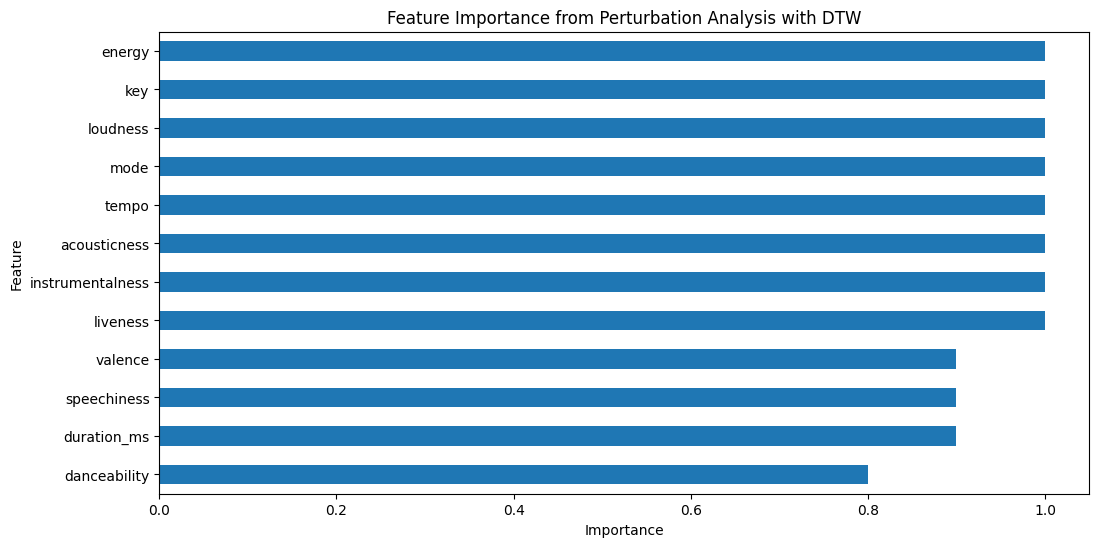

In [9]:
import matplotlib.pyplot as plt
# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Perturbation Analysis with DTW')
plt.gca().invert_yaxis()
plt.show()

In [12]:


# If you have any other objects needed for DTW, save them similarly
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(playlist_features, 'playlist_features.pkl')  # If needed
joblib.dump(playlists, 'playlists.pkl')  # If needed


NameError: name 'playlist_features' is not defined

In [15]:
# Function to fetch a random song ID
import random
def get_random_song_id(df):
    random_index = random.randint(0, len(df) - 1)
    random_song_id = df.iloc[random_index]['track_id']
    return random_song_id

# Fetch a random song ID
random_song_id = get_random_song_id(data)
print(f'Random Song ID: {random_song_id}')

Random Song ID: 1bhKFWkQ4cQtk9GOgx7jb5
